Comparison of Optimization Algorithms for Total Variation Denoising
===================================================================

This example compares the performance of ADMM, Linearized ADMM, and PDHG
in solving the isotropic total variation (TV) denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient
vectors at each point in the image $\mathbf{x}$.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize import PDHG, LinearizedADMM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Add noise to create a noisy test image.

In [3]:
σ = 1.0  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Construct operators and functionals and set regularization parameter.

In [4]:
# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
f = loss.SquaredL2Loss(y=y)
λ = 1e0
g = λ * functional.L21Norm()

For reasons that are not entirely clear, the first step of the first-run
solver is much slower than the following steps. Perform a preliminary
solver step, the result of which is discarded, to avoid this bias in the
timing results.

In [5]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=1,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 1}),
)
solver_admm.solve()
# trailing semi-colon suppresses output in notebook

DeviceArray([[-0.24786378, -1.1357064 ,  0.70034224, ..., -0.8544904 ,
               0.6193556 , -0.96835613],
             [-0.6209454 ,  0.78341496,  1.4034017 , ..., -1.3127649 ,
               1.0881042 , -0.52992207],
             [ 1.105892  ,  0.77157974,  1.6384547 , ...,  0.10172758,
              -0.9911049 , -1.2500165 ],
             ...,
             [-1.1386423 ,  0.04489064, -0.33038834, ..., -0.3450503 ,
               1.7291038 ,  0.8153052 ],
             [ 0.23897347, -1.2539679 ,  0.9339852 , ..., -0.19375205,
               1.4446731 ,  1.507419  ],
             [ 0.28059015, -0.58232814,  0.57059294, ...,  0.01591465,
              -1.2385259 ,  0.9255735 ]], dtype=float32)

Solve via ADMM with a maximum of 2 CG iterations.

In [6]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=200,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 2}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
solver_admm.solve()
hist_admm = solver_admm.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.45e-01  1.087e+05    2.558e+01  5.289e+01


  10  2.89e-01  6.892e+04    1.857e+00  3.876e+01
  20  3.61e-01  4.835e+04    1.899e+00  2.614e+01


  30  4.44e-01  3.964e+04    1.546e+00  1.607e+01
  40  5.40e-01  3.656e+04    1.140e+00  9.024e+00
  50  6.05e-01  3.565e+04    9.100e-01  4.568e+00


  60  6.86e-01  3.539e+04    5.862e-01  2.480e+00
  70  7.62e-01  3.530e+04    3.650e-01  1.409e+00
  80  8.34e-01  3.527e+04    2.217e-01  8.554e-01


  90  9.14e-01  3.526e+04    1.380e-01  5.328e-01
 100  9.98e-01  3.526e+04    8.452e-02  3.462e-01


 110  1.08e+00  3.526e+04    5.323e-02  2.325e-01
 120  1.17e+00  3.525e+04    3.649e-02  1.557e-01


 130  1.28e+00  3.525e+04    2.413e-02  1.088e-01
 140  1.37e+00  3.525e+04    1.743e-02  7.768e-02
 150  1.44e+00  3.525e+04    1.364e-02  5.588e-02


 160  1.52e+00  3.525e+04    1.128e-02  4.089e-02
 170  1.59e+00  3.525e+04    9.578e-03  2.966e-02
 180  1.66e+00  3.525e+04    8.462e-03  2.193e-02


 190  1.74e+00  3.525e+04    7.532e-03  1.627e-02
 199  1.83e+00  3.525e+04    6.867e-03  1.248e-02


Solve via Linearized ADMM.

In [7]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=1e-2,
    nu=1e-1,
    x0=y,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.22e-01  1.087e+05    2.558e+01  5.289e+01
  10  1.76e-01  8.917e+04    9.516e-01  2.399e+01
  20  2.34e-01  7.244e+04    1.057e+00  1.900e+01
  30  2.77e-01  6.075e+04    1.088e+00  1.478e+01
  40  3.20e-01  5.273e+04    1.055e+00  1.141e+01


  50  3.61e-01  4.727e+04    9.935e-01  8.829e+00
  60  4.00e-01  4.355e+04    9.018e-01  6.873e+00
  70  4.47e-01  4.102e+04    7.858e-01  5.381e+00
  80  4.98e-01  3.929e+04    6.943e-01  4.231e+00


  90  5.50e-01  3.810e+04    6.228e-01  3.350e+00
 100  5.91e-01  3.728e+04    5.452e-01  2.677e+00
 110  6.35e-01  3.671e+04    4.830e-01  2.147e+00
 120  6.85e-01  3.632e+04    4.221e-01  1.741e+00
 130  7.34e-01  3.604e+04    3.548e-01  1.417e+00


 140  7.71e-01  3.584e+04    3.086e-01  1.167e+00
 150  8.08e-01  3.569e+04    2.628e-01  9.672e-01
 160  8.47e-01  3.558e+04    2.260e-01  8.030e-01
 170  8.88e-01  3.551e+04    1.951e-01  6.740e-01


 180  9.87e-01  3.545e+04    1.699e-01  5.664e-01
 190  1.08e+00  3.540e+04    1.466e-01  4.813e-01
 199  1.14e+00  3.537e+04    1.265e-01  4.172e-01


Solve via PDHG.

In [8]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=4e-1,
    sigma=4e-1,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.31e-01  5.536e+04    2.118e+02  2.923e+02
  10  3.51e-01  3.687e+04    8.880e+00  1.540e+01
  20  3.95e-01  3.585e+04    2.550e+00  6.817e+00
  30  4.42e-01  3.558e+04    1.145e+00  4.096e+00


  40  4.87e-01  3.547e+04    6.492e-01  2.847e+00
  50  5.40e-01  3.541e+04    4.219e-01  2.153e+00
  60  5.85e-01  3.537e+04    2.954e-01  1.715e+00
  70  6.30e-01  3.535e+04    2.210e-01  1.414e+00
  80  6.70e-01  3.534e+04    1.670e-01  1.204e+00


  90  7.12e-01  3.532e+04    1.361e-01  1.038e+00
 100  7.56e-01  3.531e+04    1.164e-01  9.023e-01
 110  8.08e-01  3.531e+04    9.387e-02  7.948e-01
 120  8.67e-01  3.530e+04    7.800e-02  7.121e-01


 130  9.23e-01  3.530e+04    6.576e-02  6.443e-01
 140  9.67e-01  3.529e+04    5.890e-02  5.865e-01
 150  1.01e+00  3.529e+04    5.096e-02  5.372e-01
 160  1.05e+00  3.529e+04    4.431e-02  4.947e-01
 170  1.09e+00  3.528e+04    3.957e-02  4.587e-01


 180  1.13e+00  3.528e+04    3.615e-02  4.267e-01
 190  1.17e+00  3.528e+04    3.216e-02  3.995e-01
 199  1.21e+00  3.528e+04    2.968e-02  3.773e-01


Plot results. It is worth noting that:
- PDHG outperforms ADMM both with respect to iterations and time.
- ADMM greatly outperforms Linearized ADMM with respect to iterations.
- ADMM slightly outperforms Linearized ADMM with respect to time. This is
  possible because the ADMM $\mathbf{x}$-update can be solved relatively
  cheaply, with only 2 CG iterations. If more CG iterations were required,
  the time comparison would be favorable to Linearized ADMM.

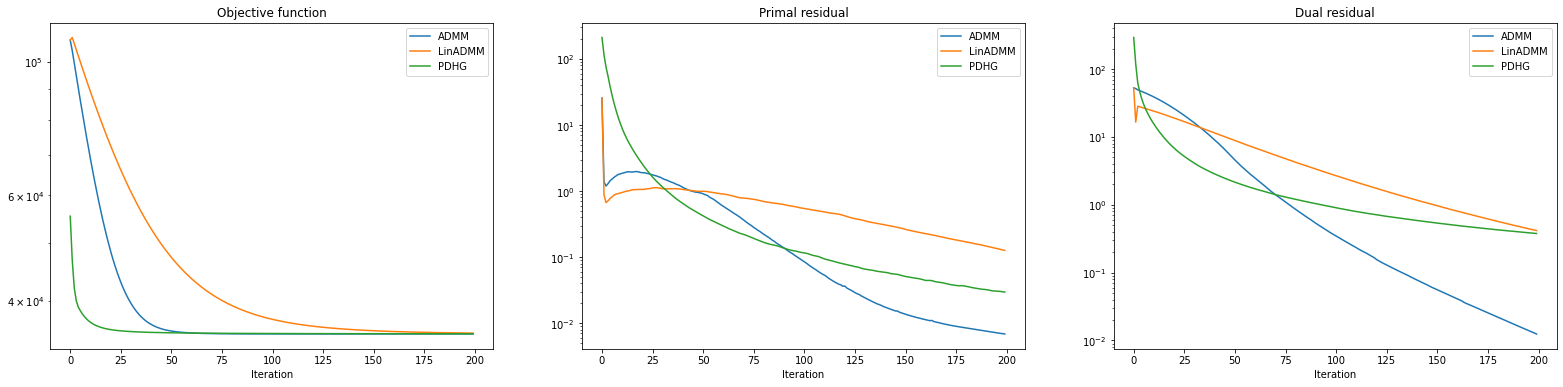

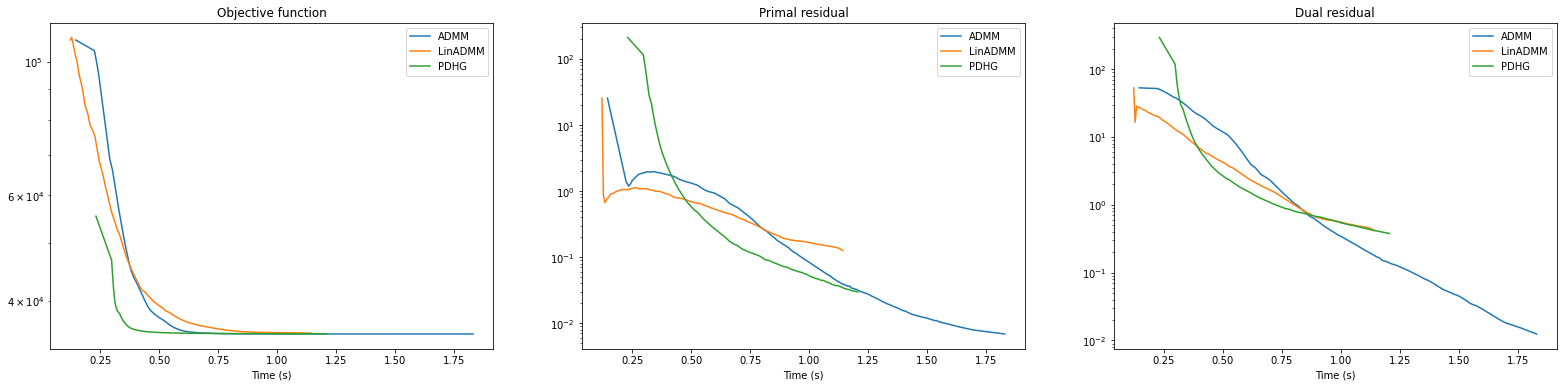

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Primal_Rsdl, hist_ladmm.Primal_Rsdl, hist_pdhg.Primal_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Primal_Rsdl, hist_ladmm.Primal_Rsdl, hist_pdhg.Primal_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()